<a href="https://colab.research.google.com/github/hajsf/Time-Series-Forecast/blob/main/06_ConsumeModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mount google drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import glob
import numpy as np

In [22]:
# import required library
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import pickle
from xgboost import plot_importance

**Read the csv files**


*   Define correct seperator, tab in our example
*   Use dtype to enforce data type mainy in casefield field has mix data types
*   Use low_memory=False so you do not mind whatever type the undefined fields are read in they have mix data





In [6]:
path = "/content/drive/MyDrive/ColabNotebooks/dataset/02_ProcessedData/"

**Load Future known features**

In [8]:
data = pd.read_csv(path + 'Future.csv', sep=',', lineterminator='\r', low_memory=False) # , dtype={"DATE1": 'string', "SLS_CNTR_ID": "string", "ITEM_ID": "string"}

In [9]:
data.head()

,DATE1,SLS_CNTR_ID,isSalaryweek,AcademicCalendarSemester,isWeekend,isRamadan,isRamadanEnd,isEid,isNationalday
0,\n8/1/2022,58.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,\n8/2/2022,58.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,\n8/3/2022,58.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,\n8/4/2022,58.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,\n8/5/2022,58.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


**Clean future data**

In [10]:
data = data.replace('\n','', regex=True)

In [11]:
data.head()

,DATE1,SLS_CNTR_ID,isSalaryweek,AcademicCalendarSemester,isWeekend,isRamadan,isRamadanEnd,isEid,isNationalday
0,8/1/2022,58.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,8/2/2022,58.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,8/3/2022,58.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,8/4/2022,58.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,8/5/2022,58.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


**Format future data data (dates, string, numbers, ..)**

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32 entries, 0 to 31
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   DATE1                     32 non-null     object 
 1   SLS_CNTR_ID               31 non-null     float64
 2   isSalaryweek              31 non-null     float64
 3   AcademicCalendarSemester  31 non-null     float64
 4   isWeekend                 31 non-null     float64
 5   isRamadan                 31 non-null     float64
 6   isRamadanEnd              31 non-null     float64
 7   isEid                     31 non-null     float64
 8   isNationalday             31 non-null     float64
dtypes: float64(8), object(1)
memory usage: 2.4+ KB


In [16]:
data

,DATE1,SLS_CNTR_ID,isSalaryweek,AcademicCalendarSemester,isWeekend,isRamadan,isRamadanEnd,isEid,isNationalday
0,8/1/2022,58.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,8/2/2022,58.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,8/3/2022,58.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,8/4/2022,58.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,8/5/2022,58.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
5,8/6/2022,58.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
6,8/7/2022,58.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,8/8/2022,58.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,8/9/2022,58.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,8/10/2022,58.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**Drop the row if single column is NAN**

In [17]:
data = data.dropna() #data.dropna(subset=['SLS_CNTR_ID']) 

In [18]:
data

,DATE1,SLS_CNTR_ID,isSalaryweek,AcademicCalendarSemester,isWeekend,isRamadan,isRamadanEnd,isEid,isNationalday
0,8/1/2022,58.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,8/2/2022,58.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,8/3/2022,58.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,8/4/2022,58.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,8/5/2022,58.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
5,8/6/2022,58.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
6,8/7/2022,58.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,8/8/2022,58.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,8/9/2022,58.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,8/10/2022,58.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
data['DATE1'] = pd.to_datetime(data['DATE1'], format='%m/%d/%Y')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


**Load Model**

In [20]:
with open(path + 'model.pk', 'rb') as f:
  model = pickle.load(f)
print("model:", model)

model: XGBRegressor(early_stopping_rounds=50, learning_rate=0.01, missing=nan,
             n_estimators=1000, objective='reg:squarederror')


RoundUp and RoundDown functions

In [31]:
from math import floor, ceil

def roundDown(n, d=8):
    d = int('1' + ('0' * d))
    return floor(n * d) / d

def roundUp(n, d=8):
    d = int('1' + ('0' * d))
    return ceil(n * d) / d

In [34]:
roundDown(3.2, 0)

3.0

**Make detection**

In [24]:
data = data.drop(columns=['DATE1'])

In [35]:
data = data.drop(columns=['ForecastedQty'])

In [36]:
data['ForecastedQty'] = model.predict(data)

In [37]:
data['ForecastedQty'] = round(data['ForecastedQty'], 0) # or use floor() or ceil()

In [38]:
data

,SLS_CNTR_ID,isSalaryweek,AcademicCalendarSemester,isWeekend,isRamadan,isRamadanEnd,isEid,isNationalday,ForecastedQty
0,58.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0
1,58.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0
2,58.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0
3,58.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0
4,58.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,12.0
5,58.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,12.0
6,58.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0
7,58.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0
8,58.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0
9,58.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0


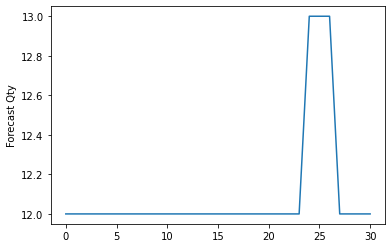

In [39]:
import matplotlib.pyplot as plt
plt.plot(data['ForecastedQty'])
plt.ylabel('Forecast Qty')

ax = plt.gca()
ax.set_xlim([xmin, xmax])
ax.set_ylim([ymin, ymax])
plt.xlim(right=xmax) #xmax is your value
plt.xlim(left=xmin) #xmin is your value
plt.ylim(top=ymax) #ymax is your value
plt.ylim(bottom=ymin) #ymin is your value

plt.show()

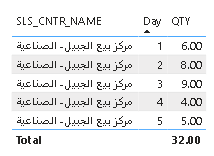